In [1]:
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.4.2     ✔ dplyr   0.7.4
✔ tidyr   0.8.0     ✔ stringr 1.3.0
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [2]:
data_dir <- file.path("..", "data")

In [3]:
tableone <- data.table::fread(file.path(data_dir, "tableone_raw.csv"), data.table = FALSE)
head(tableone)

cov,ctrl.x,trtd.x,pval.x,smd.x,ctrl.y,trtd.y,smd.y,pval.y
n,3099,3262,,NA,1626,1626,NA,NA
age,66.69 (17.21),65.74 (16.55),0.026,0.056,66.58 (16.54),65.84 (17.07),0.044,0.209
gender,50.8%,47.8%,0.016,0.061,48.0%,49.0%,0.021,0.572
first_careunit,77.6%,79.5%,0.067,0.047,78.4%,78.9%,0.014,0.734
weight,78.56 (23.58),83.17 (26.87),<0.001,0.182,81.35 (24.69),79.50 (23.11),0.077,0.060
saps,19.63 (5.79),20.76 (5.44),<0.001,0.202,20.29 (5.42),19.80 (5.17),0.092,0.008


In [4]:
tableone <- tableone %>%
select(cov, pval.x, smd.x, pval.y, smd.y)

head(tableone)

cov,pval.x,smd.x,pval.y,smd.y
n,,NA,NA,NA
age,0.026,0.056,0.209,0.044
gender,0.016,0.061,0.572,0.021
first_careunit,0.067,0.047,0.734,0.014
weight,<0.001,0.182,0.060,0.077
saps,<0.001,0.202,0.008,0.092


In [5]:
smd_tab <- tableone %>%
select(cov, smd.x, smd.y) %>%
gather("key", "value", smd.x, smd.y) %>%
filter(!is.na(value), value != "") %>%
mutate(value = gsub("<", "", value)) %>%
mutate(value = as.numeric(value))

str(smd_tab)

'data.frame':	80 obs. of  3 variables:
 $ cov  : chr  "age" "gender" "first_careunit" "weight" ...
 $ key  : chr  "smd.x" "smd.x" "smd.x" "smd.x" ...
 $ value: num  0.056 0.061 0.047 0.182 0.202 0.277 0.207 0.226 0.227 0.192 ...


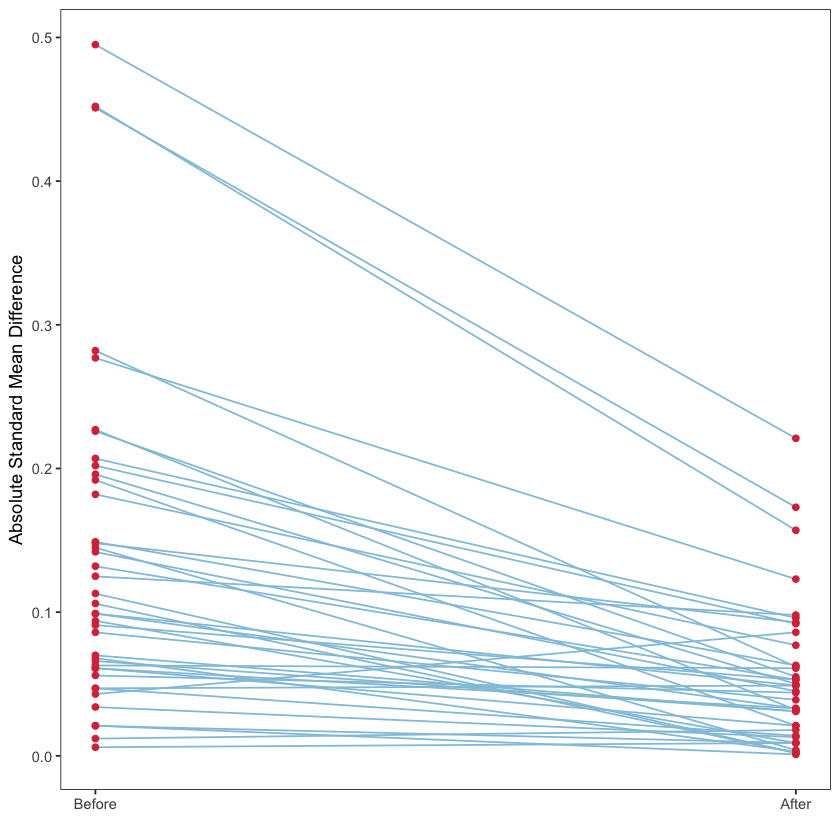

In [6]:
ggplot() +
geom_segment(data = smd_tab %>% spread(key, value),
             aes(x = 0, y = smd.x, xend = 1, yend = smd.y), color = "#92c5de") +
geom_point(data = smd_tab %>%
           mutate(key = case_when(
               key == "smd.x" ~ 0L,
               key == "smd.y" ~ 1L
           )), aes(x = key, y = value), color = "#dc3545") +
scale_x_continuous(breaks = c(0, 1), labels = c("Before", "After")) +
labs(x = "", y = "Absolute Standard Mean Difference") +
theme_bw() +
theme(panel.grid = element_blank())

In [7]:
pval_tab <- tableone %>%
select(cov, pval.x, pval.y) %>%
rename(x = pval.x, y = pval.y) %>% 
gather("key", "value", x, y) %>%
filter(!is.na(value), value != "") %>%
mutate(value = gsub("<", "", value)) %>%
mutate(value = as.numeric(value)) %>%
spread(key, value) %>%
mutate(rx = rank(x, ties.method = "first"), ry = rank(y, ties.method = "first"))

pval_tab <- pval_tab %>%
select(rx, x) %>%
rename(r = rx) %>%
full_join(pval_tab %>%
          select(ry, y) %>%
          rename(r = ry), by = "r") %>%
arrange(r) %>%
gather("key", "value", x, y)

head(pval_tab)

r,key,value
1,x,0.001
2,x,0.001
3,x,0.001
4,x,0.001
5,x,0.001
6,x,0.001


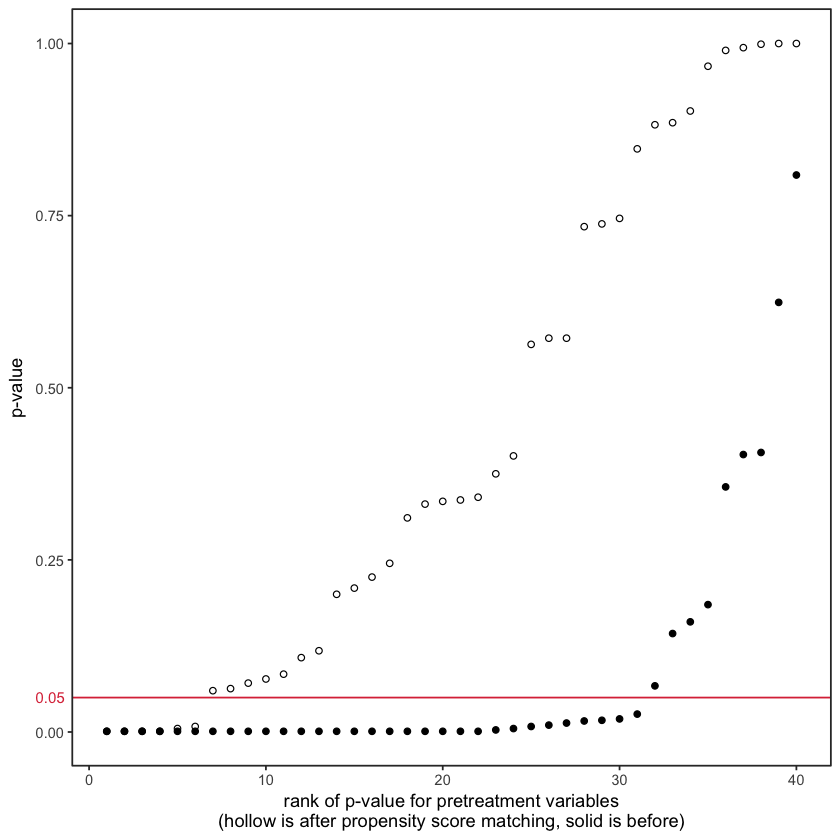

In [8]:
p <- ggplot() +
geom_point(data = pval_tab, aes(x = r, y = value, shape = key), show.legend = FALSE) +
geom_hline(yintercept = 0.05, color = "#dc3545") +
scale_shape_manual(values = c(19, 1)) +
annotation_custom(grid::textGrob("0.05",
                                 gp = grid::gpar(col = "#dc3545", fontsize = 9.1)), 
        xmin = -2.2, xmax = -2.2, ymin = 0.05, ymax = 0.05) +
labs(y = "p-value",
     x = "rank of p-value for pretreatment variables\n(hollow is after propensity score matching, solid is before)") +
theme_bw() +
theme(panel.grid = element_blank())

g <- ggplotGrob(p)
g$layout$clip[g$layout$name=="panel"] <- "off"
grid::grid.draw(g)